## Practical 10: Presenting Data

Visualisation and Tables

> **Important**
>
> This practical focusses on the final topic we want to cover in
> *Foundations*: visualisation! You will have seen and learned quite a
> bit of this across the preceding weeks, but it was done in an *ad-hoc*
> way, here we try to systematise things a bit.

> **🔗 Connections**
>
> Here we’re trying to tidy up the loose ends. You’ve already worked
> with basic data visualisations in Seaborn and Matplotlib (including
> (geo)panda’s `plot` function), but we want you to have a better sense
> of how that *works* as part of a coherent – if altogether rather
> complex and overwhelming – approach to managing a data visualisation.

## 1. Preamble

In [1]:
import os
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
from requests import get
from functools import wraps

def check_cache(f):
    @wraps(f)
    def wrapper(src:str, dst:str, min_size=100) -> Path:
        if src.find('?') == -1:
            url = Path(src)
        else:
            url = Path(src[:src.find('?')])
        fn  = url.name  # Extract the filename
        dsn = Path(f"{dst}/{fn}") # Destination filename
        if dsn.is_file() and dsn.stat().st_size > min_size:
            print(f"+ {dsn} found locally!")
            return(dsn)
        else:
            print(f"+ {dsn} not found, downloading!")
            return(f(src, dsn))
    return wrapper

@check_cache
def cache_data(src:Path, dst:Path) -> str:
    """Downloads a remote file.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dst : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
      
    # Create any missing directories in dest(ination) path
    # -- os.path.join is the reverse of split (as you saw above)
    # but it doesn't work with lists... so I had to google how
    # to use the 'splat' operator! os.makedirs creates missing
    # directories in a path automatically.
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True, exist_ok=True)
        
    # Download and write the file
    with dst.open(mode='wb') as file:
        response = get(src)
        file.write(response.content)
        
    print(' + Done downloading...')

    return dst.resolve()

## 2. Using Maplotlib

### 2.1 Anatomy of a Figure

> **Tip**
>
> You might want to bookmark the ‘Anatomy of a Figure’ image so that you
> can easily find and refer to it in the future. This structure is why
> `matplotlib` is so much nastier than `ggplot`, but it does also give
> you greater *control* over the output if you really dig into the guts
> of things.

*One* of the reasons that Matplotlib is so much more complex than
`ggplot` is that it can actually *do* a lot more than ggplot, including
image manipulation, axis translation, and even 3D. You can get a sense
of this by looking at [the
tutorials](https://matplotlib.org/stable/tutorials/index.html) since the
[Users guide](https://matplotlib.org/stable/users/index.html) can be a
bit overwhelming.

Nevertheless, the [core components of all matplotlib
figures](https://matplotlib.org/stable/gallery/showcase/anatomy.html)
can be seen here:

<img src="https://matplotlib.org/stable/_images/sphx_glr_anatomy_001.png" alt="Anatomy of a Figure" style="width:75%" />

### 2.2 Finding Fonts

I find matplotlib’s use of fonts to be *profoundly* weird. If you use
`conda` and install directly on to the computer then you *might* have
access to all of your computer’s fonts (though there are different
*types* of fonts as well, not all of which will show up), but for most
users it will be those that were installed into Podman.

#### 2.2.1 Listing Fonts

> **Warning**
>
> Depending on how you are running the notebook, you may not be able to
> see all of the fonts available on your system. If the notebook is
> running in a Podman container it only has access to the fonts that are
> installed in the container. In other words: **don’t panic if you don’t
> see the font(s) you want.**.

In [3]:
from matplotlib import font_manager
from IPython.core.display import HTML

flist = font_manager.findSystemFonts()
names = []
for fname in flist:
    try:
        names.append(font_manager.FontProperties(fname=fname).get_name())
    except RuntimeError:
        pass # Think the issue is emoji-support/colour fonts

print(f"Found {len(set(names))} fonts.")

def make_html(fontname):
    return f"<p><span style='font-family: {fontname}; font-size: 18px;'>{fontname}</p>"

code = "\n".join([make_html(font) for font in sorted(set(names)) if not font.startswith('.')])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

Found 42 fonts.

Big Shoulders Display 
 Cousine 
 DejaVu Sans 
 EB Garamond 
 Font Awesome 5 Brands 
 Font Awesome 5 Free 
 Font Awesome 6 Brands 
 Font Awesome 6 Free 
 Font Awesome v4 Compatibility 
 Hanken Grotesk 
 Inconsolata 
 Inconsolata Condensed 
 Inconsolata Expanded 
 Inconsolata ExtraCondensed 
 Inconsolata ExtraExpanded 
 Inconsolata SemiCondensed 
 Inconsolata SemiExpanded 
 Inconsolata UltraCondensed 
 Inconsolata UltraExpanded 
 Inter Tight 
 League Gothic 
 Liberation Mono 
 Liberation Sans 
 Liberation Serif 
 Lobster 
 Micro 5 
 Roboto Flex 
 Roboto Mono 
 Roboto Slab 
 Silkscreen 
 Source Code Pro 
 Source Sans 3 
 Source Sans Pro 
 Source Serif 4 
 Source Serif 4 18pt 
 Source Serif 4 36pt 
 Source Serif 4 48pt 
 Spectral 
 Spectral SC 
 Ubuntu 
 Ubuntu Condensed 
 Ubuntu Mono

#### 2.2.2 Using Fontconfig

`fontconfig` is the base Linux utility for managing fonts. We can list
font using `fc-list` and then a set of ‘switches’ determining the kind
of information we want back. Since fontconfig doesn’t exist on OSX or
Windows, you’ll need to do some more investigating and poking around to
get these details on a `conda` install (I’ll show an option further
down)…

Here we ask fontconfig to format the output so that we only get the
first part of the family name, and then we pipe (recall `|` sends output
from one utility to another!) the output of that to `sort`, which sorts
the output, and `uniq` which removes duplicates (which there will be
because there are **bold**, *italic*, small-caps, etc. versions of each
font). To make better sense of this you can always try playing around
with all three steps in the output below!

In [4]:
fonts = ! fc-list --format="%{family[0]}\n" | sort | uniq
print(fonts[:5])

['Big Shoulders Display', 'Bitstream Charter', 'Courier', 'Cousine', 'DejaVu Sans']

> **Capturing output**
>
> Notice that we’re able to capture the output of an external
> application (called via the Terminal) with `fonts = ! ...`. This can
> be useful when something is easy to do on the command line but hard to
> do in Python.

The below option also pipes output from fonctconfig, but to the `grep`
utility which checks each line for the character sequence `Liberation`.
Now we’re asking fontconfig to include `style` details which will relate
to both weight (regular, bold, extra bold, light, etc.) and italic,
bold, small caps, etc.

In [5]:
fonts = ! fc-list : family style | grep "Liberation"
print(sorted(fonts)[:5])

['Liberation Mono:style=Bold', 'Liberation Mono:style=Bold Italic', 'Liberation Mono:style=Italic', 'Liberation Mono:style=Regular', 'Liberation Sans:style=Bold']

You can find more examples
[here](https://www.geeksforgeeks.org/fc-list-command-in-linux-with-examples/),
a more detailed set of instructions
[here](https://www.freedesktop.org/software/fontconfig/fontconfig-user.html),
and even information about (for example) [supported
languages](https://thottingal.in/blog/2016/03/04/fontconfig-language-matching/)
based on [RFC
3066](http://www.i18nguy.com/unicode/language-identifiers.html).

Here are the languages supported by the Ubuntu Light font:

In [6]:
langs = ! fc-list "Liberation Mono" : lang
print(sorted(langs)[:5], "...")

[':lang=aa|ab|af|ast|av|ay|az-az|ba|bm|be|bg|bi|bin|br|bs|bua|ca|ce|ch|chm|co|cs|cu|cv|cy|da|de|el|en|eo|es|et|eu|fi|fj|fo|fr|ff|fur|fy|ga|gd|gl|gn|gv|ha|haw|he|ho|hr|hu|ia|ig|id|ie|ik|io|is|it|kaa|ki|kk|kl|ku-am|kum|kv|kw|ky|la|lb|lez|ln|lt|lv|mg|mh|mi|mk|mo|mt|nb|nds|nl|nn|no|nr|nso|ny|oc|om|os|pl|pt|rm|ro|ru|sah|sco|se|sel|sh|shs|sk|sl|sm|sma|smj|smn|sms|so|sq|sr|ss|st|sv|sw|tg|tk|tl|tn|to|tr|ts|tt|tw|tyv|uk|uz|ve|vi|vo|vot|wa|wen|wo|xh|yap|yi|yo|zu|ak|an|ber-dz|crh|csb|ee|fat|fil|hsb|ht|hz|jv|kab|kj|kr|ku-tr|kwm|lg|li|mn-mn|ms|na|ng|nv|pap-an|pap-aw|qu|quz|rn|rw|sc|sg|sn|su|ty|za|agr|ayc|bem|dsb|lij|mfe|mhr|miq|mjw|nhn|niu|rif|sgs|szl|tpi|unm|wae|yuw'] ...

Here are the monospace fonts installed:

In [7]:
monos = ! fc-list :spacing=mono : family | sort | uniq
print(sorted(monos)[:5], "...")

['Courier', 'Cousine', 'Inconsolata', 'Inconsolata Condensed', 'Inconsolata Condensed,Inconsolata Condensed Black'] ...

#### 2.2.3 Fontdicts

Now that we know what’s available, the next step is to set up some
useful defaults that we can re-use across multiple plots to ensure
consistency of output. The format for specifying fonts on a per-figure
basis is a dictionary, so where you see `fontdict` in the `matplotlib`
[documentation](https://matplotlib.org/stable/gallery/text_labels_and_annotations/text_fontdict.html)
the following should work:

Here’s the example:

In [8]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

In [9]:
ff='Liberation Sans'
tfont = {'fontname':ff}
bfont = {'fontname':ff, 'weight':'bold', 'horizontalalignment':'left'}
afont = {'fontname':ff}

I am setting the ‘title font’ (`tfont`) and ‘body copy font’ (`bfont`)
and ‘axis font’ (`afont`) here to use in the output below. You can pick
another font and see what happens.

#### 2.2.4 2.3: Using Fonts

At this point we’re going to work towards a kind of ‘atlas’ that would
make it easy to compare some features for different London boroughs. I
basically implemented a the basic `matplotlib` version of QGIS’ Atlas
functionality.

In [10]:
# This will be whatever LA you processed last week
LA = 'Waltham Forest'

In [11]:
msoa_gdf = gpd.read_parquet(os.path.join('data','geo',f'{LA}-MSOA_data.geoparquet'))

In [12]:
median_gdf  = msoa_gdf[['MSOA11CD','median_price','geometry']]
listing_gdf = msoa_gdf[['MSOA11CD','listing_count','geometry']]

In [13]:
import matplotlib.pyplot as plt

#### 2.2.5 The Defaults

Here is a demonstration of some of the ways you can adjust features in a
Python matplotlib plot. I’m not suggesting either of these is a *good*
output, but that’s not the point! The idea is to see the various ways
you can tweak a plot… And notice that we’ve not yet changed any fonts.
And it shows.

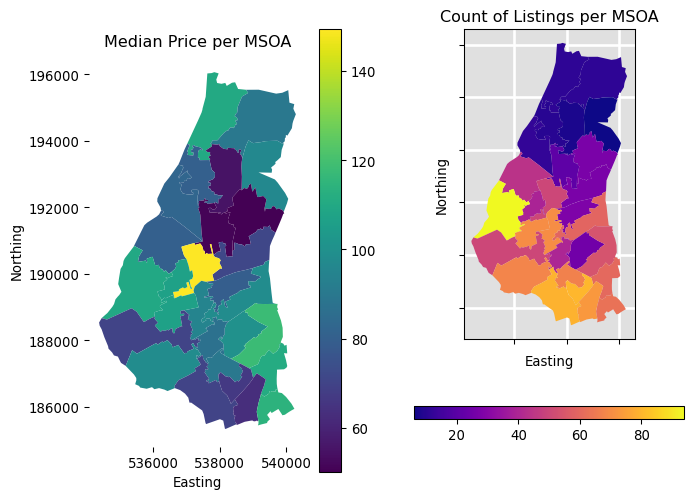

In [14]:
# Set up a 1 x 2 plot (you can also leave off the nrows= and ncols=)
f,axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
# ax1 will be the first plot on the left, ax2 will be on the right;
# a 2 (or more) *row* plot will return a list of lists... 1 list/row.
ax1 = axes[0]
ax2 = axes[1]

# Left plot is the median price
median_gdf.plot(column='median_price', ax=ax1, legend=True, cmap='viridis')
ax1.set_title("Median Price per MSOA");
# Turn off the frame, one side of the plat at a time
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
# Set the labels
ax1.set_xlabel("Easting");
ax1.set_ylabel("Northing");

# Right plot is the number of listings; note
# here the use of both zorder (which is the 
# 'stacking order' of elements on the plot, and
# the legend_kwds (keywords) to change the 
# orientation of the plot to horizontal
listing_gdf.plot(column='listing_count', ax=ax2, legend=True, cmap='plasma', zorder=1, 
                 legend_kwds={"orientation": "horizontal"})
ax2.set_title("Count of Listings per MSOA");
# Set a background colour for the plot
ax2.set_facecolor((.4, .4, .4, .2))
# Add grid lines and set their zorder to
# below that of the data on the plot
plt.grid(visible=True, which='major', axis='both', color='w', linestyle='-', linewidth=2, zorder=0)
ax2.set_axisbelow(True)

# This is equivalent to the ax1.spines... 
# above, but if you use it here you lose
# the background to the plot as well!
#plt.gca().set(frame_on=False)

# Remove the labels on the ticks of the 
# axes (meaning: remove the numbers on 
# x- and y-axes).
ax2.set_xticklabels([])
ax2.set_yticklabels([])

# Set the labels
ax2.set_xlabel("Easting");
ax2.set_ylabel("Northing");

#### 2.2.6 Improving on Defaults

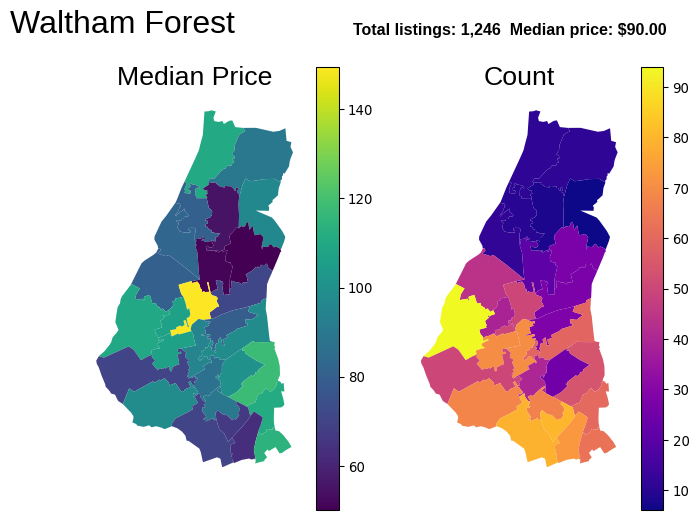

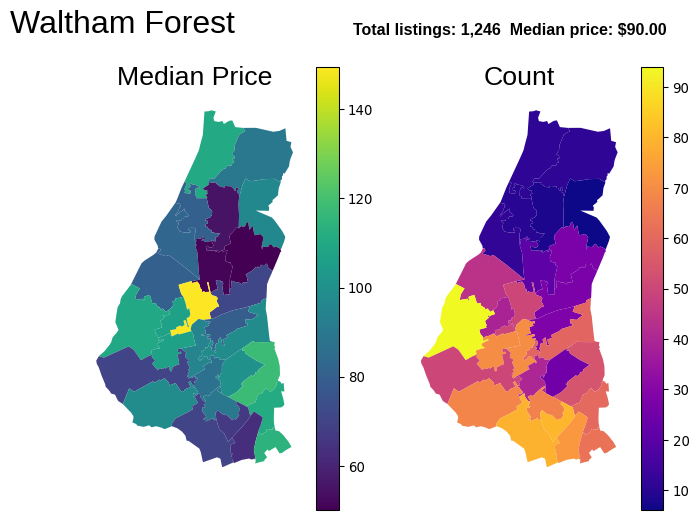

In [15]:
f,axes = plt.subplots(1,2,figsize=(8,6))

# Set up the plots
median_gdf.plot(column='median_price', ax=axes[0], legend=True, cmap='viridis')
listing_gdf.plot(column='listing_count', ax=axes[1], legend=True, cmap='plasma')
for ax in axes:
    ax.axis('off')
    # Note that here, set_facebolor doesn't work,
    # presumably because the axis is 'off'
    ax.set_facecolor((.4, .4, .4, .2))

# Add the 'super-title', but notice that it is not 
# longer either centered (x=0.025) or centre-aligned
# (horizonal alignment=left). We also see **tfont, which
# is a way of expading the 'tfont' dictionary into a 
# set of parameters to a function call. We do the same
# for the titles on each figure, but passing a different
# fontdict.
f.suptitle(LA, x=0.025, ha='left', size=24, **tfont)
axes[0].set_title('Median Price', size=20, **afont)
axes[1].set_title('Count', size=20, **afont)

# And add a short piece of text below the borough
plt.figtext(x=0.88, y=0.957, linespacing=1.4, va='top', ha='right', size=12, 
            s=f"Total listings: {listing_gdf['listing_count'].sum():,.0f}  Median price: ${median_gdf['median_price'].median():,.2f}", **bfont);
f

## 3. Create an Atlas

### 3.1 Adding Picture-in-Picture

We’re now going to emulate a *bit* of QGIS’ Atlas function by creating
two subplots and then adding a *third* plot afterwards that shows where
the borough is.

+ data/geo/Boroughs.gpkg found locally!

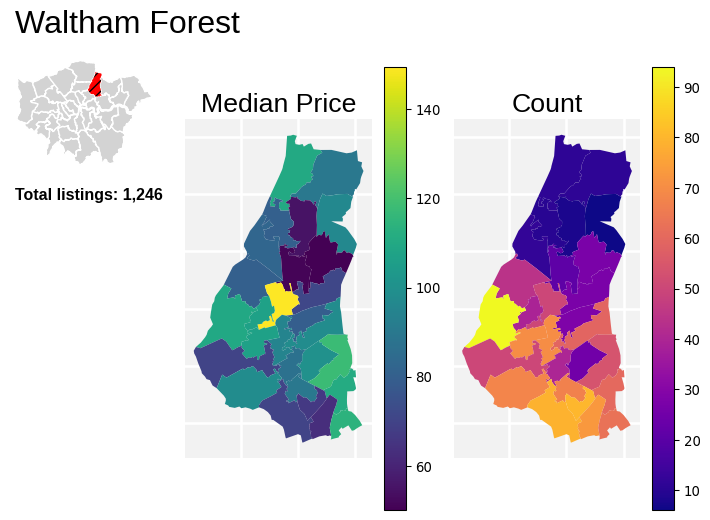

In [16]:
f,axes = plt.subplots(1,3,gridspec_kw={'width_ratios':[1,4,4]}, figsize=(8,6))

# Plot 0 is basically being used as a 'spacer' 
# as you'll see below
axes[0].axis('off')

# Plot 1 is the median price
median_gdf.plot(column='median_price', ax=axes[1], legend=True, cmap='viridis')
axes[1].set_title('Median Price', size=20, **afont)

# Plot 2 is the count of listings
listing_gdf.plot(column='listing_count', ax=axes[2], legend=True, cmap='plasma')
axes[2].set_title('Count', size=20, **afont)

# For plots 1 and 2... if you were doing this a lot it could be a function!
for ax in axes[1:]:
    ax.set_facecolor((.9, .9, .9, .5))
    ax.grid(visible=True, which='major', axis='both', color='w', linestyle='-', linewidth=2, zorder=0)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', length=0)

# Add a *third* chart that we use as a kind of 'PiP'
# to show which borough we're talking about. The 
# add_axes call is here taking information about the
# positioning and size of the additional figure.
# Disable ax2.axis('off') if you want to see the
# figure in full.
ax3 = f.add_axes([0.015, 0.7, 0.2, 0.2])
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path
ddir  = os.path.join('data','geo') # destination directory
boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
boros.plot(facecolor='lightgrey', edgecolor='w', linewidth=1, ax=ax3)
boros[boros.NAME==LA].plot(facecolor='r', edgecolor='none', hatch='///', ax=ax3)
ax3.axis('off')

# Add the 'super-title', but notice that it is not 
# longer either centered (x=0.025) or centre-aligned
# (horizonal alignment=left). We also see **tfont, which
# is a way of expanding the 'tfont' dictionary into a 
# set of parameters to a function call. We do the same
# for the titles on each figure, but passing a different
# fontdict.
f.suptitle(LA, x=0.025, ha='left', size=24, **tfont)

# And add a short piece of text below the borough
plt.figtext(x=0.025, y=0.65, s=f"Total listings: {listing_gdf['listing_count'].sum():,.0f}", size=12, **bfont);

### 3.2 Bonus Achievement Unlocked!

If you have the time and inclination, see if you can convert the above
to an *actual* atlas output:

1.  You’ll want to turn this plot into a function so as to be able to
    produce (and save) the map for *every* borough.
2.  You’ll even need to parameterise the filename so that you save to
    *different* PNG files as well as going back to see how we generated
    the listing and pricing data frames for the Local Authority…
3.  And you’ll *also* need to make sure that you ensure a consistent
    colour bar (for all of London, because the median price and number
    of listings will vary rather a lot by LA)
4.  Then there’s the placement of the PiP for some boroughs with long
    names
5.  And finally, you might consider adding some more text to atlas–maybe
    pull some content from Wikipedia using Beautiful Soup (`bs4`)?

## 4. Think Text!

I also wanted to draw your attention to this [outstanding
piece](https://blog.datawrapper.de/text-in-data-visualizations/) on
using text effectively in data visualisation: we often add labels as
afterthoughts without too much regard for where they go or how they
look; however, getting the content, positioning, size, and even
font/font-weight ‘right’ can make all the difference to the
effectiveness of your chart! The illustrations are top-notch.

And see the bibliography at the end!

> **Bookmark Me!**
>
> Basically, bookmark [this blog
> post](https://blog.datawrapper.de/text-in-data-visualizations/) and
> refer to it every time you are making a map or chart.

## 5. Using Bokeh

> **Bokeh in Jupyter**
>
> This last section currently doesn’t seem to work since I updated the
> course materials for the current year. So you *could* check out the
> old image `jreades/sds:2024-silicon` (or `-intel`) but it’s up to you.
> If I work out why this is happening I will fix it and either update
> the code or update the image.

Bokeh can do a *lot* more than this, but I just wanted to give you a
flavour of the other visualisation tools supported by Python. This
obviously works *very* differently in setup and use.

In [17]:
gdf_la = gpd.read_parquet(os.path.join('data','geo','Listings_with_LA.geoparquet'))
msoas  = gpd.read_parquet(os.path.join('data','geo','London_MSOA_Names.geoparquet'))

### 5.1 For a Chart

Group the listings by Borough and Room Type, and aggregate by median
price, also producing a count variable for the number of listings of
each type in each Borough.

In [18]:
la_tots = gdf_la[gdf_la.NAME==LA].groupby(by='room_type', observed=False).agg(
                            {'price':'median', 'listing_url':'count'}
                        ).reset_index().rename(columns={'listing_url':'count'})
la_tots

In [19]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Spectral4
from bokeh.models import CustomJS, Dropdown

output_notebook()

room_types = la_tots.room_type.to_list()
prices     = la_tots.price.to_list()
counts     = la_tots['count'].to_list()

# Add hover tooltip
source = ColumnDataSource(data=dict(
    rt=room_types,
    count=counts,
    price=prices,
))

TOOLTIPS = [
    ("Room Type", "@rt"),
    ("Number of Listings", "@count{,}"),
    ("Median Price", "$@price{,}/night")
]

p = figure(x_range=room_types, height=300, tooltips=TOOLTIPS,
           title=f"Median Price by Room Type in {LA}",
           toolbar_location=None, tools="")

p.vbar(x='rt', top='count', width=0.9, source=source)
p.xgrid.grid_line_color = None
p.y_range.start = 0

show(p)

Loading BokehJS ...

### 5.2 For a Map

This is not the prettiest code, but it should work…

In [20]:
from bokeh.plotting import figure

from bokeh.io import output_file, show, output_notebook, push_notebook, export_png
from bokeh.models import ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.plotting import figure
from bokeh.palettes import brewer

#output_notebook()

In [21]:
msoadf = gpd.sjoin(
            gdf_la[gdf_la.NAME==LA].reset_index(), 
            msoas[msoas.Borough==LA].drop(columns=['index_right']), predicate='within')

In [22]:
msoagrdf = msoadf.groupby('MSOA11NM').agg({'price':['median','count']}).reset_index()
msoagrdf.columns=['msoa11nm','median','count']

I cobbled the mapping functions below together from two tutorials I
found online ([this
one](https://github.com/dmnfarrell/teaching/blob/master/geo/maps_python.ipynb)
and [this
one](https://widdowquinn.github.io/Teaching-Data-Visualisation/exercises/interactive_bokeh_map/interactive_bokeh_map.html)).
As you can see, this is a very different approach to mapping data, but
it has clear benefits for exploratory purposes and produces fast,
interactive maps… and I’ve not even added selection and filtering tools!

In [23]:
import json

def get_geodatasource(gdf):    
    """Get getjsondatasource from geopandas object"""
    json_data = json.dumps(json.loads(gdf.to_json()))
    return GeoJSONDataSource(geojson = json_data)

def bokeh_plot_map(gdf, column=None, title=''):
    """Plot bokeh map from GeoJSONDataSource """

    geosource = get_geodatasource(gdf)
    palette = brewer['OrRd'][8]
    palette = palette[::-1]
    vals = gdf[column]
    
    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette=palette, low=vals.min(), high=vals.max())
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8, width=500, height=10,
                         location=(0,0), orientation='horizontal')

    tools = 'wheel_zoom,pan,reset,hover'
    
    p = figure(title = title, height=700, width=850, toolbar_location='right', tools=tools)
    p.add_tile("CartoDB Positron", retina=True)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    # Add patch renderer to figure
    p.patches('xs','ys', source=geosource, fill_alpha=0.5, line_width=0.5, line_color='white',  
              fill_color={'field' :column , 'transform': color_mapper})
    
    # Specify figure layout.
    p.add_layout(color_bar, 'below')
    
    # Add hover
    hover = p.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [("Borough", "@Borough"),
                      ("Neighbourhood", "@msoa11hclnm"),
                      ("Count of Listings", "@count"),
                      ("Median Price", "$@median")]
    
    return p

Reproject to Web Mercator:

In [24]:
msoa_gdf = pd.merge(msoagrdf, msoas, left_on='msoa11nm', right_on='MSOA11NM', how='inner')
msoa_gdf = msoa_gdf.set_geometry('geometry').set_crs('epsg:27700')

In [25]:
msoageo = msoa_gdf.to_crs('epsg:3785')
msoageo.total_bounds

array([-6.74542047e+03,  6.71906611e+06,  3.04361304e+03,  6.73637453e+06])

And map it!

In [26]:
# Need to drop the right geometry column
# as Bokeh doesn't know how to handle two
# and tries to 'serialise' the second geom.
p = bokeh_plot_map(msoageo.drop(columns=['geometry_right','index_right']), 'median', title=f'MSOA-Level Activity in {LA}')

handle = show(p, notebook_handle=True)
push_notebook(handle=handle)

> **🔗 Connections**
>
> And that’s it. That’s all she wrote! You’ve now covered in \<10 weeks
> what many people might take 10 *months* to cover. So do not feel like
> either: 1) you know it all; or 2) you know nothing. You have learned a
> *lot*, but it’s probably just enough to see how much you *don’t* know.
> And *that* is the start of wisdom. Good luck, young Python-master!